In [87]:
## which state has the most sightings? over time?
## most frequent shape by state?
## timeline changes? trends?
## sighting density around airports/afb

In [88]:
import os
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [89]:
ufo_df = pd.read_csv('resources/ufo.csv', low_memory=False)

In [90]:
nRow, nCol = ufo_df.shape
print(f'This csv has {nRow} rows and {nCol} columns')

This csv has 80332 rows and 11 columns


In [91]:
#split datetime into date and time and move them to the front of the df

ufo_df[['date', 'time']] = ufo_df.datetime.str.split(' ', expand=True)

ufo_df['date'] = pd.to_datetime(ufo_df.date, infer_datetime_format = True)
display(ufo_df.head())

first_column = ufo_df.pop('time')
ufo_df.insert(0, 'time', first_column)

first_column = ufo_df.pop('date')
ufo_df.insert(0, 'date', first_column)

ufo_df.pop('datetime')

ufo_df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,date,time
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,1949-10-10,20:30
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,1949-10-10,21:00
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,1955-10-10,17:00
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,1956-10-10,21:00
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,1960-10-10,20:00


,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,1949-10-10,20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,1949-10-10,21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,1955-10-10,17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,1956-10-10,21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,1960-10-10,20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [92]:
#convert 'duration' column from object to float64

ufo_df.rename(columns = {'duration (seconds)':'duration_sec'}, inplace = True)

ufo_df["duration_sec"] = pd.to_numeric(ufo_df.duration_sec, errors='coerce')

In [93]:
ufo_df.dtypes

date                    datetime64[ns]
time                            object
city                            object
state                           object
country                         object
shape                           object
duration_sec                   float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                        object
longitude                      float64
dtype: object

In [94]:
ufo_df['shape'].value_counts()

light        16565
triangle      7865
circle        7608
fireball      6208
other         5649
unknown       5584
sphere        5387
disk          5213
oval          3733
formation     2457
cigar         2057
changing      1962
flash         1328
rectangle     1297
cylinder      1283
diamond       1178
chevron        952
egg            759
teardrop       750
cone           316
cross          233
delta            7
round            2
crescent         2
pyramid          1
flare            1
hexagon          1
dome             1
changed          1
Name: shape, dtype: int64

In [95]:
ufo_df['state'].value_counts()

ca    9655
wa    4268
fl    4200
tx    3677
ny    3219
      ... 
nf      25
nt      20
pe      17
yt      13
yk       7
Name: state, Length: 67, dtype: int64

In [96]:
ufo_df.nunique()

date                    10525
time                     1391
city                    19900
state                      67
country                     5
shape                      29
duration_sec              533
duration (hours/min)     8349
comments                79997
date posted               317
latitude                18445
longitude               19455
dtype: int64

In [97]:
ufo_df['date'].value_counts().head(20)

2010-07-04    202
2012-07-04    182
1999-11-16    180
2013-07-04    176
2011-07-04    146
2009-09-19    126
2014-01-01     93
2013-12-31     89
2004-10-31     85
2009-07-04     84
2013-07-06     78
2013-01-01     70
2012-12-31     69
1997-03-13     69
2012-01-01     69
2011-07-03     67
1997-07-04     65
2012-08-18     65
2008-07-04     62
1999-09-01     60
Name: date, dtype: int64

In [102]:
bins = [1940, 1959, 1969, 1979, 1989, 1999, 2009, 2015]


labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

ufo_df['Date Bin'] = pd.cut(ufo_df.date.dt.year, bins, labels=labels, right=False)

date_shape = ufo_df.groupby(['Date Bin']).size().reset_index(name='count')
date_shape

         

,Date Bin,count
0,1950-1959,480
1,1960-1969,1200
2,1970-1979,2290
3,1980-1989,2052
4,1990-1999,6660
5,2000-2009,37046
6,2010-2015,30585


In [103]:
date_shape = ufo_df.groupby(['Date Bin']).size()
date_shape

Date Bin
1950-1959      480
1960-1969     1200
1970-1979     2290
1980-1989     2052
1990-1999     6660
2000-2009    37046
2010-2015    30585
dtype: int64

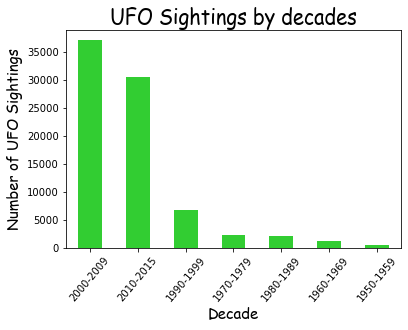

In [128]:
group = ufo_df["Date Bin"].value_counts()
group.plot(kind = "bar",color="limegreen")
plt.xticks(rotation=50)
plt.xticks(rotation=50)

plt.title("UFO Sightings by decades", fontdict= {'fontname':'Comic Sans MS','fontsize':20})
plt.ylabel("Number of UFO Sightings",fontdict= {'fontname':'Comic Sans MS','fontsize':15})
plt.xlabel("Decade",fontdict= {'fontname':'Comic Sans MS','fontsize':15})
plt.show()


In [130]:
bins = [1940, 1959, 1969, 1979, 1989, 1999, 2009, 2015]


labels = ['1950-1959','1960-1969','1970-1979','1980-1989','1990-1999','2000-2009','2010-2015']

ufo_df['Date Bin'] = pd.cut(ufo_df.date.dt.year, bins, labels=labels, right=False)

date_shape = ufo_df.groupby(['Date Bin','state']).size().reset_index(name='count')
date_shape.head(55)

,Date Bin,state,count
0,1950-1959,ab,2
1,1950-1959,ak,6
2,1950-1959,al,5
3,1950-1959,ar,5
4,1950-1959,az,2
5,1950-1959,bc,3
6,1950-1959,ca,65
7,1950-1959,co,10
8,1950-1959,ct,4
9,1950-1959,dc,1


In [ ]:
counts = combined_df['Drug Regimen'].value_counts()
x_axis = np.arange(len(counts))
plt.bar(x_axis, counts, color="orange",align="center" )

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, counts.index.values)
plt.xticks(rotation=50)
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Data Points")
plt.title('Number of Data Points for Drug Regimen')
plt.show()